In [1]:
import numpy as np
import os
from torchaudio.datasets import SPEECHCOMMANDS
import numpy as np
import librosa
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

2024-04-21 22:29:53.711720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Utiliser CLASStorchaudio.datasets.SPEECHCOMMANDS pour telecharger le dataset
class SpeechCommands(SPEECHCOMMANDS):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, n):
        waveform, sample_rate, label, speaker_id, utterance_number = super().__getitem__(n)
        return waveform, sample_rate, label, speaker_id, utterance_number

    def __len__(self):
        return super().__len__()

# Charger le dataset
def load_dataset():
    dataset = SpeechCommands(root='speech_commands_v0.02', download=True)
    return dataset

def load_data(dataset):
    X = []
    y = []
    for i in range(len(dataset)):
        waveform, sample_rate, label, speaker_id, utterance_number = dataset[i]
        X.append(waveform.numpy())
        y.append(label)
    return X, y

X, y = load_data(load_dataset())



# Utiliser la fonction load_data pour charger les données


100%|██████████| 2.26G/2.26G [04:40<00:00, 8.66MB/s] 


In [2]:
# generate training list = all samples - validation_list - testing_list
if os.path.exists('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/train_list.txt')==False:
    with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/validation_list.txt', 'r') as f:
        val_list = f.readlines()

    with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/testing_list.txt', 'r') as f:
        test_list = f.readlines()

    val_test_list = list(set(test_list+val_list))

    def get_immediate_subdirectories(a_dir):
        return [name for name in os.listdir(a_dir) if os.path.isdir(os.path.join(a_dir, name))]
    def get_immediate_files(a_dir):
        return [name for name in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, name))]

    base_path = 'speech_commands_v0.02/SpeechCommands/speech_commands_v0.02'
    all_cmds = get_immediate_subdirectories(base_path)
    all_list = []
    for cmd in all_cmds:
        if cmd != '_background_noise_':
            cmd_samples = get_immediate_files(base_path+'/'+cmd)
            for sample in cmd_samples:
                all_list.append(cmd + '/' + sample+'\n')

    training_list = [x for x in all_list if x not in val_test_list]

    with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/train_list.txt', 'w') as f:
        f.writelines(training_list)

label_set = np.loadtxt('speech_commands_v0.02/SpeechCommands/speechcommands_class_labels_indices.csv', delimiter=',', dtype='str')
label_map = {}
for i in range(1, len(label_set)):
    label_map[eval(label_set[i][2])] = label_set[i][0]
    
print(label_map)


{'backward': '0', 'follow': '1', 'five': '2', 'bed': '3', 'zero': '4', 'on': '5', 'learn': '6', 'two': '7', 'house': '8', 'tree': '9', 'dog': '10', 'stop': '11', 'seven': '12', 'eight': '13', 'down': '14', 'six': '15', 'forward': '16', 'cat': '17', 'right': '18', 'visual': '19', 'four': '20', 'wow': '21', 'no': '22', 'nine': '23', 'off': '24', 'three': '25', 'left': '26', 'marvin': '27', 'yes': '28', 'up': '29', 'sheila': '30', 'happy': '31', 'bird': '32', 'go': '33', 'one': '34'}


In [3]:
#charger les données d'entrainement
X_train = []
y_train = []
with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/train_list.txt', 'r') as f:
    train_list = f.readlines()
    for sample in train_list:
        sample = sample.replace('\n', '')
        # needs to use the full path like 'speech_commands_v0.02/'+ sample
        path = 'speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/'+ sample
        waveform = librosa.load(path, sr=16000)[0]
        label = sample.split('/')[0]
        X_train.append(waveform)
        y_train.append(label)


X_test = []
y_test = []
with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/testing_list.txt', 'r') as f:
    test_list = f.readlines()
    for sample in test_list:
        sample = sample.replace('\n', '')
        path = 'speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/'+ sample
        waveform = librosa.load(path, sr=16000)[0]
        label = sample.split('/')[0]        
        X_test.append(waveform)
        y_test.append(label)

X_val = []
y_val = []
with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/validation_list.txt', 'r') as f:
    val_list = f.readlines()
    for sample in val_list:
        sample = sample.replace('\n', '')
        path = 'speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/'+ sample
        waveform = librosa.load(path, sr=16000)[0]
        label = sample.split('/')[0]
        X_val.append(waveform)
        y_val.append(label)

In [23]:
print(type(label_map['right']))

<class 'numpy.str_'>


In [77]:
#transformer lable map values en entiers
label_map = {k: v for v, k in enumerate(label_map.keys())}


y_train_encoded = np.array([label_map[i] for i in y_train if i in label_map.keys()] )
y_test_encoded = np.array([label_map[i] for i in y_test if i in label_map.keys()])
y_val_encoded = np.array([label_map[i] for i in y_val if i in label_map.keys()])

from keras.utils import to_categorical

num_classes = 35 
y_train_encoded = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_encoded = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)



In [25]:
print(type(y_train_encoded[0]))

<class 'int'>


/var/folders/j9/536nrb8d6g12rb8p0d0f02ph0000gn/T/ipykernel_1632/1385426286.py:32: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
/var/folders/j9/536nrb8d6g12rb8p0d0f02ph0000gn/T/ipykernel_1632/1385426286.py:35: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D_augmented, ref=np.max), y_axis='log', x_axis='time')


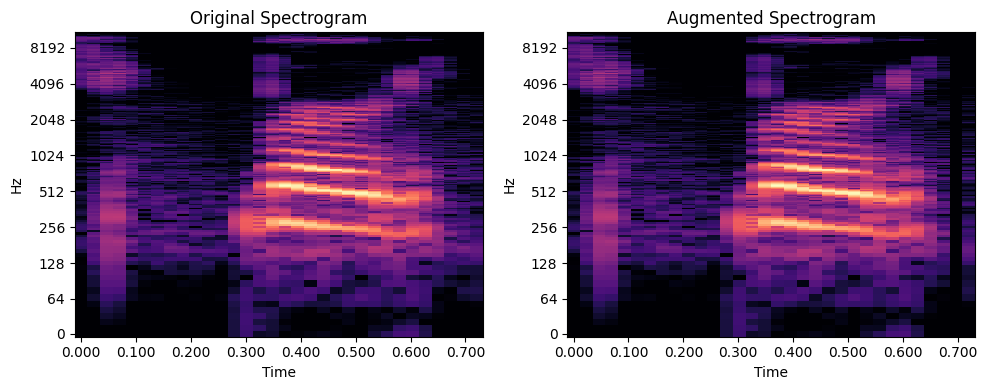

In [52]:
audio_path = 'speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/bird/0a7c2a8d_nohash_0.wav'
y, sr = librosa.load(audio_path, sr=None)
D = librosa.stft(y)


def time_mask(spec, T=5):
    num_time = spec.shape[1]
    t = np.random.uniform(low=0.0, high=num_time)
    t = int(t)
    t_mask = np.random.randint(low=0, high=T)
    mask = np.ones_like(spec)
    mask[:, t:t + t_mask] = 0
    return mask

def freq_mask(spec, F=5):
    num_freq = spec.shape[0]
    f = np.random.uniform(low=0.0, high=num_freq)
    f = int(f)
    f_mask = np.random.randint(low=0, high=F)
    mask = np.ones_like(spec)
    mask[f:f + f_mask, :] = 0
    return mask


# utiliser la fonction time_mask et freq_mask pour creer un masque aleatoire
# appliquer le masque sur le spectrogramme
mask = time_mask(D) * freq_mask(D)
D_augmented = np.multiply(D, mask)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Original Spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(D_augmented, ref=np.max), y_axis='log', x_axis='time')
plt.title('Augmented Spectrogram')
plt.tight_layout()
plt.show()

In [15]:
sr = 16000
def data_agmentation(waveform,param):
    # Ajouter du bruit
    #param = list
    # si param contient 1, ajouter du bruit
    if 1 in param:
        noise = np.random.normal(0, 0.01, waveform.shape)
        waveform = waveform + noise
    # ajouter un décalage
    if 2 in param:
        shift = np.random.randint(low=-sr // 10, high=sr // 10)
        return np.roll(waveform, shift)
    # masking
    if 3 in param:  
        D = librosa.stft(waveform)
        mask = time_mask(D) * freq_mask(D)
        D_augmented = np.multiply(D, mask)
        waveform = librosa.istft(D_augmented)
    
    # Pitch shifting
    if 4 in param:
        n_steps = np.random.randint(low=-2, high=3)
        waveform = librosa.effects.pitch_shift(waveform, sr = sr, n_steps = n_steps)
    
    # Speed Change
    if 5 in param:
        speed_change = np.random.uniform(low=0.9, high=1.1)
        waveform = librosa.effects.time_stretch(waveform, rate=speed_change)
    
    return waveform
    

In [67]:
from librosa.feature import mfcc
def extract_features(waveform, parmetre, bool_augmentation=False):
    # pad the sequence to have the same length for all files (une secondes)
    waveform = torch.tensor(waveform)
    if waveform.shape[0] < 16000:
        waveform = torch.nn.functional.pad(waveform, (0, 16000 - waveform.shape[0]),value=0)
    else:
        waveform = waveform[:16000]

    waveform = waveform.numpy()
    # augment the data
    if bool_augmentation:
        waveform = data_agmentation(waveform,parmetre)
        # extract the features
        if 3 in parmetre or 5 in parmetre:
            waveform = torch.tensor(waveform)
            if waveform.shape[0] < 16000:
                waveform = torch.nn.functional.pad(waveform, (0, 16000 - waveform.shape[0]),value=0)
            else:
                waveform = waveform[:16000]

            waveform = waveform.numpy()
            
        waveform = mfcc(y = waveform,sr=16000, n_mfcc=13,  n_fft=400, hop_length=640,win_length = 320, n_mels=23, fmin=0.0, fmax=8000)
    
    else:
        waveform = mfcc(y = waveform,sr=16000, n_mfcc=13,  n_fft=400, hop_length=640,win_length = 320, n_mels=23, fmin=0.0, fmax=8000)
    
    return waveform
        

def X_trans(X_entry,param, bool_augmentation=False):
    X_entry = np.array([extract_features(waveform,param,bool_augmentation) for waveform in X_entry])
    
    return X_entry

def X_(X_train,X_test,X_val,param,bool_augmentation):
    X_train = X_trans(X_train,param,bool_augmentation)
    X_test =  X_trans(X_test,[],False)
    X_val =  X_trans(X_val,[],False)

    # Normalisation
    scaler = StandardScaler()
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train,X_test,X_val
    


In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# matrice de confusion et courbe d'apprentissage
        
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_courbe(model):
    plt.figure(figsize=(12, 4))

    # plot accuracy during training et validation
    plt.subplot(1, 2, 1)
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # plot loss during training et validation
    plt.subplot(1, 2, 2)
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [8]:
# Sans augmentation
X_train_Non,X_test_Non,X_val_Non = X_(X_train,X_test,X_val,[],True)

In [61]:
print(X_train_Non.shape)

(84843, 338)


In [68]:
# Avec masking
X_train_masking,_,_ = X_(X_train,X_test,X_val,[3],True)


In [69]:
# fusione masking et non masking, shape = (X_train_Non)*2
X_train_masking_aug = np.concatenate((X_train_Non,X_train_masking),axis=0)
print(X_train_masking_aug.shape)


(169686, 338)


In [79]:
Y_train_aug = np.concatenate((y_train_encoded,y_train_encoded),axis=0)

In [10]:
# Avec timeshift
X_train_timeshift,_,_ = X_(X_train,X_test,X_val,[2],True)

In [82]:
X_train_timeshift_aug = np.concatenate((X_train_Non,X_train_timeshift),axis=0)

In [37]:
# Avec bruit
X_train_noise,_,_ = X_(X_train,X_test,X_val,[1],True) 
#X_train_noise = X_trans(X_train,[1],True)

In [84]:
X_train_noise_aug = np.concatenate((X_train_Non,X_train_noise),axis=0)

In [12]:
print(X_train_Non.shape, X_test_Non.shape, X_val_Non.shape)

(84843, 338) (11005, 338) (9981, 338)


In [38]:
# Avec pitch shifting
X_train_Pitch,_,_ = X_(X_train,X_test,X_val,[4],True) 

In [85]:
X_train_Pitch_aug = np.concatenate((X_train_Non,X_train_Pitch),axis=0)

In [39]:
# Avec speed change
X_train_Speed,_,_ = X_(X_train,X_test,X_val,[5],True)

In [86]:
X_train_Speed_aug = np.concatenate((X_train_Non,X_train_Speed),axis=0)

### Regression Logistic

In [11]:
model_LR1 = LogisticRegression()
model_LR1.fit(X_train, y_train)

y_pred_val = model_LR1.predict(X_val)
y_pred_test = model_LR1.predict(X_test)

print( f"L'acc de validation du modèle Logistic Regression est de : {accuracy_score(y_val, y_pred_val)}")
print( f"L'acc de test du modèle Logistic Regression est de : {accuracy_score(y_test, y_pred_test)}")


############################################Sans Norm################################################################


model_LR2 = LogisticRegression()
model_LR2.fit(X_train_NonNormalized, y_train)

y_pred_val = model_LR2.predict(X_val_NonNormalized)
y_pred_test = model_LR2.predict(X_test_NonNormalized)

print( f"L'acc de validation du modèle Logistic Regression sans normalisation est de : {accuracy_score(y_val, y_pred_val)}")
print( f"L'acc de test du modèle Logistic Regression sans normalisation est de : {accuracy_score(y_test, y_pred_test)}")


L'acc de validation du modèle Logistic Regression est de : 0.4247069431920649
L'acc de test du modèle Logistic Regression est de : 0.39691049522944116
L'acc de validation du modèle Logistic Regression sans normalisation est de : 0.4016631600040076
L'acc de test du modèle Logistic Regression sans normalisation est de : 0.3785552021808269


/Users/zhile/M1-S2/DALAS/selenium_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### SVM

In [7]:
# Creer un modele SVM
from sklearn.svm import SVC
model_SVC1 = SVC()
# ce modele svc ustilise un kernel Gaussien
model_SVC1.fit(X_train_Non, y_train)
y_pred = model_SVC1.predict(X_val)
y_pred_test = model_SVC1.predict(X_test)

print( f"L'acc de validation du modèle SVM est de : {accuracy_score(y_val, y_pred)}")
print( f"L'acc de test du modèle SVM est de : {accuracy_score(y_test, y_pred_test)}")


############################################Sans Norm################################################################

# model_SVC2 = SVC()
# # ce modele svc ustilise un kernel Gaussien
# model_SVC2.fit(X_train_NonNormalized, y_train)

# y_pred = model_SVC2.predict(X_val_NonNormalized)
# y_pred_test = model_SVC2.predict(X_test_NonNormalized)

# print( f"L'acc de validation du modèle SVM sans normalisation est de : {accuracy_score(y_val, y_pred)}")
# print( f"L'acc de test du modèle SVM sans sormalisation est de : {accuracy_score(y_test, y_pred_test)}")

### MLP

In [35]:
# Creer un modele MLP avec 2 couches cachées de 100 et 50 neurones en utilisant pytorch

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(338, 500)
        self.fc2 = nn.Linear(500, 35)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = torch.softmax(self.fc2(x))
        x = self.fc2(x)

        return x
    
def train(model, criterion, optimizer, train_loader):
    model.train()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    return model


def validate(model, criterion, val_loader):
    model.eval()
    # Trouver best-model
    best_loss = 1000
    best_model = model
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(val_loader):
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            if loss < best_loss:
                best_loss = loss
                best_model = model

    return best_model, best_loss

def test(model, criterion, test_loader,epoch):
    """Test the model on the test set for a number of epoch"""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_loader):
            y_pred = model(X_batch)
            test_loss += criterion(y_pred, y_batch).item()
            pred = y_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y_batch.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    print(f"Epoch {epoch}: Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.2f}%)\n")
    return test_accuracy



X_val_tensor = torch.tensor(X_val_Non, dtype=torch.float32)
y_val_tensor = torch.tensor([list(label_map.keys()).index(label) for label in y_val], dtype=torch.long)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)

X_test_tensor = torch.tensor(X_test_Non, dtype=torch.float32)
y_test_tensor = torch.tensor([list(label_map.keys()).index(label) for label in y_test], dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

In [21]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_Non, dtype=torch.float32)
y_train_tensor = torch.tensor([list(label_map.keys()).index(label) for label in y_train], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



best_model = model
best_accuracy = 0
for epoch in range(20):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0348, Accuracy: 7445/11005 (0.68%)

Epoch 1: Test set: Average loss: 0.0331, Accuracy: 7751/11005 (0.70%)

Epoch 2: Test set: Average loss: 0.0330, Accuracy: 7849/11005 (0.71%)

Epoch 3: Test set: Average loss: 0.0338, Accuracy: 7882/11005 (0.72%)

Epoch 4: Test set: Average loss: 0.0345, Accuracy: 8033/11005 (0.73%)

Epoch 5: Test set: Average loss: 0.0378, Accuracy: 7994/11005 (0.73%)

Epoch 6: Test set: Average loss: 0.0397, Accuracy: 7907/11005 (0.72%)

Epoch 7: Test set: Average loss: 0.0413, Accuracy: 7983/11005 (0.73%)

Epoch 8: Test set: Average loss: 0.0441, Accuracy: 7982/11005 (0.73%)

Epoch 9: Test set: Average loss: 0.0469, Accuracy: 7979/11005 (0.73%)

Epoch 10: Test set: Average loss: 0.0502, Accuracy: 7923/11005 (0.72%)

Epoch 11: Test set: Average loss: 0.0533, Accuracy: 7943/11005 (0.72%)

Epoch 12: Test set: Average loss: 0.0559, Accuracy: 7894/11005 (0.72%)

Epoch 13: Test set: Average loss: 0.0582, Accuracy: 7898/11005 (0.72%)

Ep

In [21]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_timeshift, dtype=torch.float32)
y_train_tensor = torch.tensor([list(label_map.keys()).index(label) for label in y_train], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(20):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0351, Accuracy: 7435/11005 (0.68%)

Epoch 1: Test set: Average loss: 0.0321, Accuracy: 7765/11005 (0.71%)

Epoch 2: Test set: Average loss: 0.0320, Accuracy: 7915/11005 (0.72%)

Epoch 3: Test set: Average loss: 0.0329, Accuracy: 7946/11005 (0.72%)

Epoch 4: Test set: Average loss: 0.0344, Accuracy: 7949/11005 (0.72%)

Epoch 5: Test set: Average loss: 0.0362, Accuracy: 7950/11005 (0.72%)

Epoch 6: Test set: Average loss: 0.0379, Accuracy: 7972/11005 (0.72%)

Epoch 7: Test set: Average loss: 0.0407, Accuracy: 7925/11005 (0.72%)

Epoch 8: Test set: Average loss: 0.0441, Accuracy: 7840/11005 (0.71%)

Epoch 9: Test set: Average loss: 0.0456, Accuracy: 7930/11005 (0.72%)

Epoch 10: Test set: Average loss: 0.0485, Accuracy: 7931/11005 (0.72%)

Epoch 11: Test set: Average loss: 0.0508, Accuracy: 7889/11005 (0.72%)

Epoch 12: Test set: Average loss: 0.0544, Accuracy: 7915/11005 (0.72%)

Epoch 13: Test set: Average loss: 0.0589, Accuracy: 7846/11005 (0.71%)

Ep

In [18]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_masking, dtype=torch.float32)
y_train_tensor = torch.tensor([list(label_map.keys()).index(label) for label in y_train], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(20):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0361, Accuracy: 7350/11005 (0.67%)

Epoch 1: Test set: Average loss: 0.0334, Accuracy: 7651/11005 (0.70%)

Epoch 2: Test set: Average loss: 0.0335, Accuracy: 7759/11005 (0.71%)

Epoch 3: Test set: Average loss: 0.0344, Accuracy: 7874/11005 (0.72%)

Epoch 4: Test set: Average loss: 0.0356, Accuracy: 7964/11005 (0.72%)

Epoch 5: Test set: Average loss: 0.0399, Accuracy: 7843/11005 (0.71%)

Epoch 6: Test set: Average loss: 0.0404, Accuracy: 7914/11005 (0.72%)

Epoch 7: Test set: Average loss: 0.0443, Accuracy: 7844/11005 (0.71%)

Epoch 8: Test set: Average loss: 0.0479, Accuracy: 7780/11005 (0.71%)

Epoch 9: Test set: Average loss: 0.0495, Accuracy: 7824/11005 (0.71%)

Epoch 10: Test set: Average loss: 0.0526, Accuracy: 7816/11005 (0.71%)

Epoch 11: Test set: Average loss: 0.0559, Accuracy: 7814/11005 (0.71%)

Epoch 12: Test set: Average loss: 0.0590, Accuracy: 7853/11005 (0.71%)

Epoch 13: Test set: Average loss: 0.0618, Accuracy: 7843/11005 (0.71%)

Ep

In [40]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_noise, dtype=torch.float32)
y_train_tensor = torch.tensor([list(label_map.keys()).index(label) for label in y_train], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(20):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0616, Accuracy: 5496/11005 (0.50%)

Epoch 1: Test set: Average loss: 0.0587, Accuracy: 5894/11005 (0.54%)

Epoch 2: Test set: Average loss: 0.0599, Accuracy: 6138/11005 (0.56%)

Epoch 3: Test set: Average loss: 0.0620, Accuracy: 6276/11005 (0.57%)

Epoch 4: Test set: Average loss: 0.0699, Accuracy: 6060/11005 (0.55%)

Epoch 5: Test set: Average loss: 0.0732, Accuracy: 6154/11005 (0.56%)

Epoch 6: Test set: Average loss: 0.0773, Accuracy: 6208/11005 (0.56%)

Epoch 7: Test set: Average loss: 0.0833, Accuracy: 6162/11005 (0.56%)

Epoch 8: Test set: Average loss: 0.0870, Accuracy: 6189/11005 (0.56%)

Epoch 9: Test set: Average loss: 0.0965, Accuracy: 6113/11005 (0.56%)

Epoch 10: Test set: Average loss: 0.0991, Accuracy: 6170/11005 (0.56%)

Epoch 11: Test set: Average loss: 0.1043, Accuracy: 6152/11005 (0.56%)

Epoch 12: Test set: Average loss: 0.1134, Accuracy: 6135/11005 (0.56%)

Epoch 13: Test set: Average loss: 0.1208, Accuracy: 6130/11005 (0.56%)

Ep

In [49]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_Pitch, dtype=torch.float32)
y_train_tensor = torch.tensor([list(label_map.keys()).index(label) for label in y_train], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(20):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0382, Accuracy: 7133/11005 (0.65%)

Epoch 1: Test set: Average loss: 0.0353, Accuracy: 7497/11005 (0.68%)

Epoch 2: Test set: Average loss: 0.0352, Accuracy: 7622/11005 (0.69%)

Epoch 3: Test set: Average loss: 0.0367, Accuracy: 7648/11005 (0.69%)

Epoch 4: Test set: Average loss: 0.0377, Accuracy: 7718/11005 (0.70%)

Epoch 5: Test set: Average loss: 0.0389, Accuracy: 7753/11005 (0.70%)

Epoch 6: Test set: Average loss: 0.0418, Accuracy: 7688/11005 (0.70%)

Epoch 7: Test set: Average loss: 0.0439, Accuracy: 7714/11005 (0.70%)

Epoch 8: Test set: Average loss: 0.0471, Accuracy: 7656/11005 (0.70%)

Epoch 9: Test set: Average loss: 0.0489, Accuracy: 7676/11005 (0.70%)

Epoch 10: Test set: Average loss: 0.0535, Accuracy: 7588/11005 (0.69%)

Epoch 11: Test set: Average loss: 0.0542, Accuracy: 7716/11005 (0.70%)

Epoch 12: Test set: Average loss: 0.0592, Accuracy: 7507/11005 (0.68%)

Epoch 13: Test set: Average loss: 0.0608, Accuracy: 7593/11005 (0.69%)

Ep

In [50]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_Speed, dtype=torch.float32)
y_train_tensor = torch.tensor([list(label_map.keys()).index(label) for label in y_train], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(20):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0392, Accuracy: 7082/11005 (0.64%)

Epoch 1: Test set: Average loss: 0.0349, Accuracy: 7545/11005 (0.69%)

Epoch 2: Test set: Average loss: 0.0359, Accuracy: 7562/11005 (0.69%)

Epoch 3: Test set: Average loss: 0.0373, Accuracy: 7642/11005 (0.69%)

Epoch 4: Test set: Average loss: 0.0390, Accuracy: 7657/11005 (0.70%)

Epoch 5: Test set: Average loss: 0.0406, Accuracy: 7670/11005 (0.70%)

Epoch 6: Test set: Average loss: 0.0434, Accuracy: 7675/11005 (0.70%)

Epoch 7: Test set: Average loss: 0.0460, Accuracy: 7614/11005 (0.69%)

Epoch 8: Test set: Average loss: 0.0506, Accuracy: 7541/11005 (0.69%)

Epoch 9: Test set: Average loss: 0.0529, Accuracy: 7584/11005 (0.69%)

Epoch 10: Test set: Average loss: 0.0541, Accuracy: 7653/11005 (0.70%)

Epoch 11: Test set: Average loss: 0.0595, Accuracy: 7567/11005 (0.69%)

Epoch 12: Test set: Average loss: 0.0598, Accuracy: 7610/11005 (0.69%)

Epoch 13: Test set: Average loss: 0.0668, Accuracy: 7510/11005 (0.68%)

Ep

# CNN


In [23]:
class AudioClassifier:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape  
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=self.input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, x_train, y_train, batch_size, epochs, validation_data):
        return self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data)

    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model.predict(x)


In [32]:
print("y_train_encoded shape:", y_train_encoded.shape)
print("Type of y_train_encoded:", type(y_train_encoded))


y_train_encoded shape: (84843, 35)
Type of y_train_encoded: <class 'numpy.ndarray'>


In [87]:
X_train_Non_C = X_train_Non.reshape(-1, 13, 26, 1)
X_train_masking_C = X_train_masking_aug.reshape(-1, 13, 26, 1)
X_train_noise_C = X_train_noise_aug.reshape(-1, 13, 26, 1)
X_train_timeshift_C = X_train_timeshift_aug.reshape(-1, 13, 26, 1)
X_train_Pitch_C = X_train_Pitch_aug.reshape(-1, 13, 26, 1)
X_train_Speed_C = X_train_Speed_aug.reshape(-1, 13, 26, 1)

X_val_Non_C = X_val_Non.reshape(-1, 13, 26, 1)
X_test_Non_C = X_test_Non.reshape(-1, 13, 26, 1)

In [102]:
classifier_Non_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)
history_Non_C = classifier_Non_C.train(X_train_Non_C, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_Non_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)


/Users/zhile/M1-S2/DALAS/selenium_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 45s 16ms/step - accuracy: 0.4104 - loss: 2.0763 - val_accuracy: 0.8186 - val_loss: 0.6168
Epoch 2/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.7890 - loss: 0.7122 - val_accuracy: 0.8505 - val_loss: 0.5162
Epoch 3/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.8346 - loss: 0.5567 - val_accuracy: 0.8654 - val_loss: 0.4577
Epoch 4/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.8567 - loss: 0.4799 - val_accuracy: 0.8654 - val_loss: 0.4629
Epoch 5/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.8699 - loss: 0.4300 - val_accuracy: 0.8748 - val_loss: 0.4336
Epoch 6/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - accuracy: 0.8816 - loss: 0.3878 - val_accuracy: 0.8777 - val_loss: 0.4300
Epoch 7/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - accuracy: 0.8880 - loss: 0.3644 - val_accuracy: 0.8821 - val_loss: 0.4175
Epoch 8/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.8957 -

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


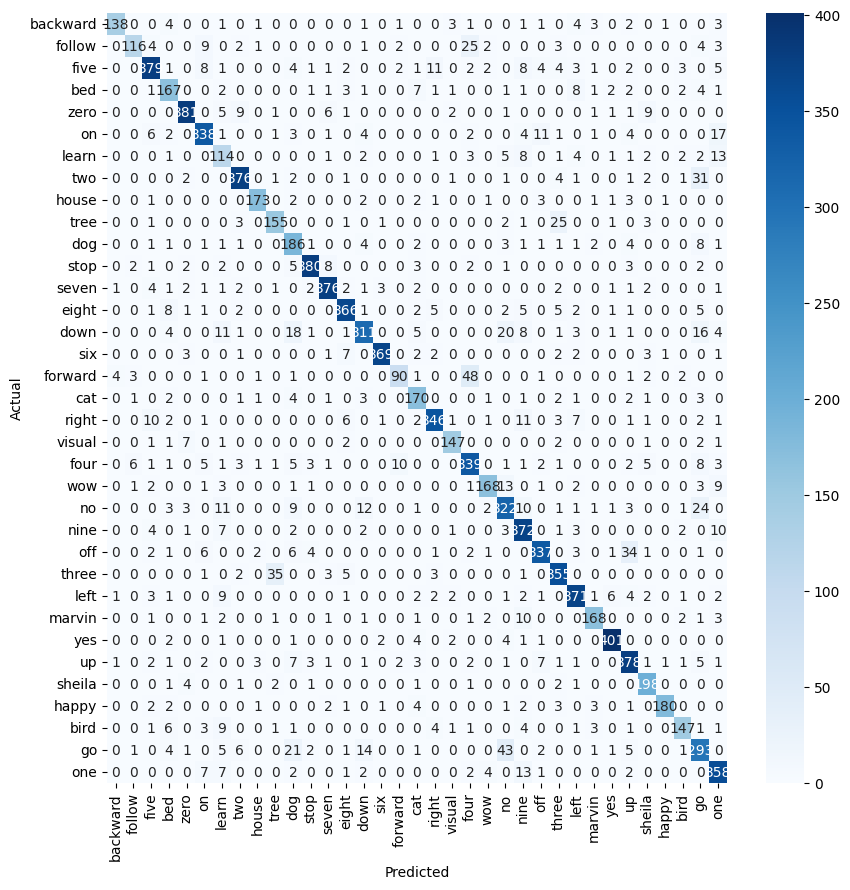

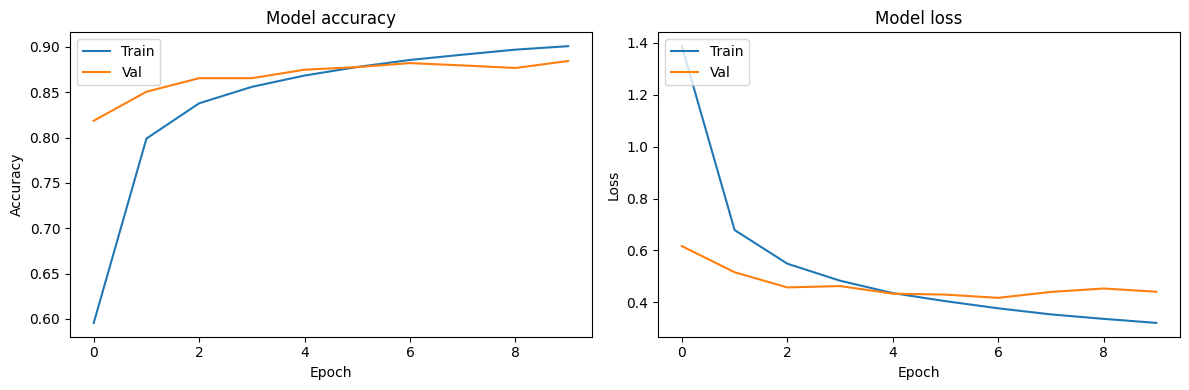

In [113]:
#matrcie de confusion
y_pred = classifier_Non_C.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_encoded, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_Non_C)

In [124]:
classifier_mask_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_mask_C = classifier_mask_C.train(X_train_masking_C, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_mask_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

/Users/zhile/M1-S2/DALAS/selenium_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 89s 16ms/step - accuracy: 0.5349 - loss: 1.6260 - val_accuracy: 0.8513 - val_loss: 0.4954
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 87s 16ms/step - accuracy: 0.8313 - loss: 0.5710 - val_accuracy: 0.8720 - val_loss: 0.4348
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 90s 17ms/step - accuracy: 0.8644 - loss: 0.4544 - val_accuracy: 0.8756 - val_loss: 0.4373
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 90s 17ms/step - accuracy: 0.8818 - loss: 0.3917 - val_accuracy: 0.8811 - val_loss: 0.4235
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 141s 17ms/step - accuracy: 0.8928 - loss: 0.3540 - val_accuracy: 0.8779 - val_loss: 0.4512
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 94s 18ms/step - accuracy: 0.9005 - loss: 0.3247 - val_accuracy: 0.8862 - val_loss: 0.4271
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - accuracy: 0.9063 - loss: 0.3018 - val_accuracy: 0.8797 - val_loss: 0.4924
Epoch 8/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - accuracy: 0.9103 

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


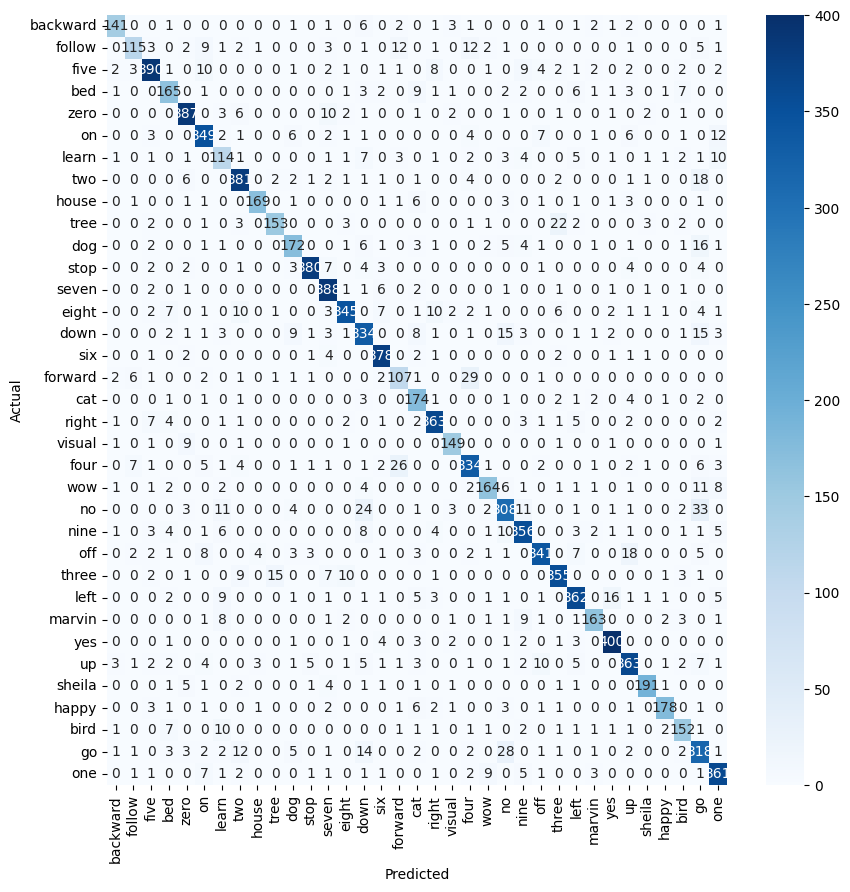

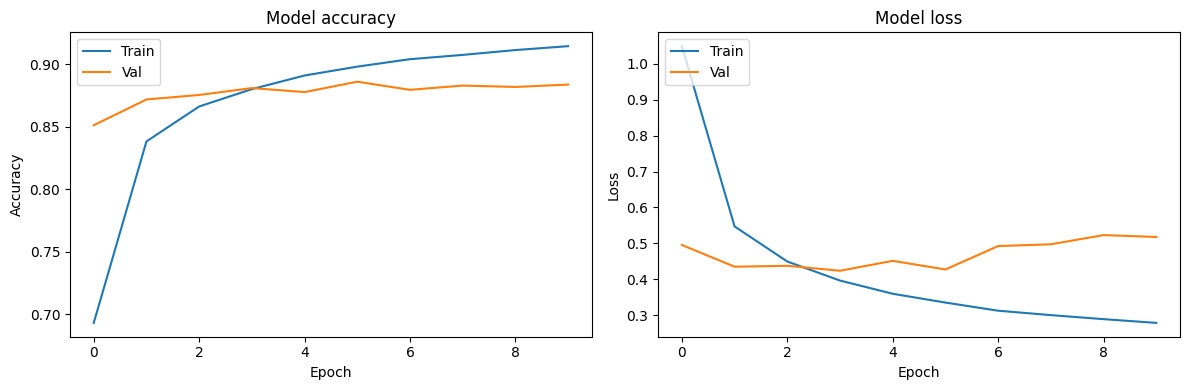

In [125]:
#matrcie de confusion
y_pred = classifier_mask_C.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_mask_C)

In [115]:
classifier_timeshift_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_timeshift_C=classifier_timeshift_C.train(X_train_timeshift_C, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_timeshift_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

/Users/zhile/M1-S2/DALAS/selenium_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 100s 18ms/step - accuracy: 0.5284 - loss: 1.6359 - val_accuracy: 0.8450 - val_loss: 0.5225
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 95s 18ms/step - accuracy: 0.8311 - loss: 0.5687 - val_accuracy: 0.8634 - val_loss: 0.4605
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.8622 - loss: 0.4630 - val_accuracy: 0.8830 - val_loss: 0.3965
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - accuracy: 0.8776 - loss: 0.4098 - val_accuracy: 0.8805 - val_loss: 0.4070
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.8864 - loss: 0.3787 - val_accuracy: 0.8836 - val_loss: 0.4039
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - accuracy: 0.8935 - loss: 0.3536 - val_accuracy: 0.8876 - val_loss: 0.3914
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 85s 16ms/step - accuracy: 0.8985 - loss: 0.3329 - val_accuracy: 0.8897 - val_loss: 0.4070
Epoch 8/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 87s 16ms/step - accuracy: 0.9008 

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


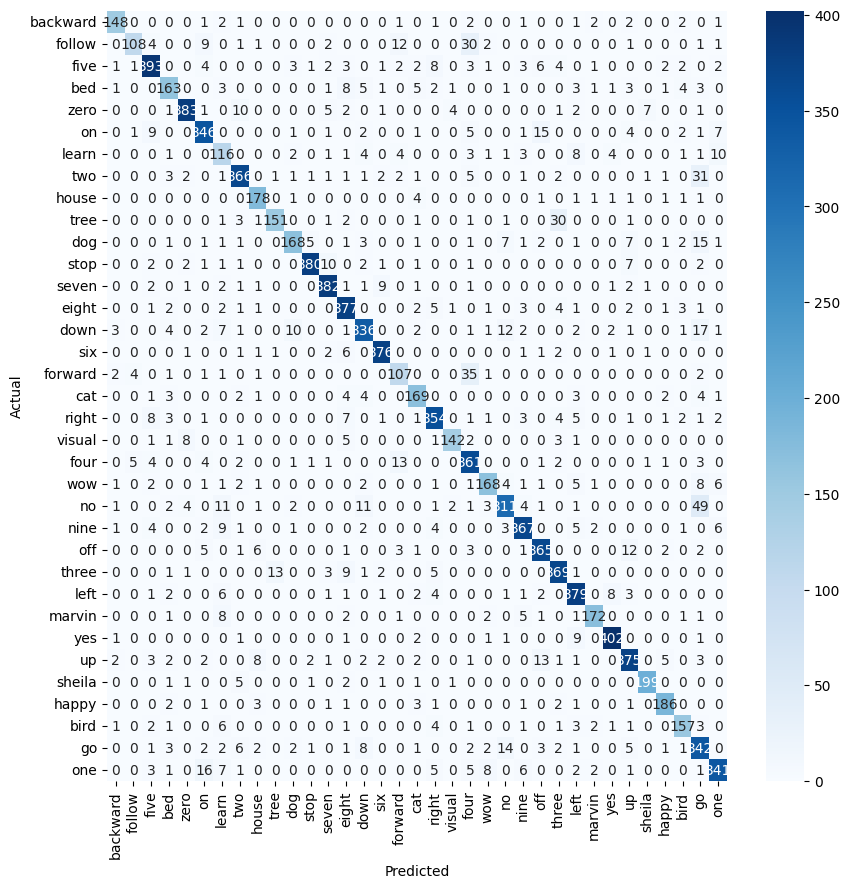

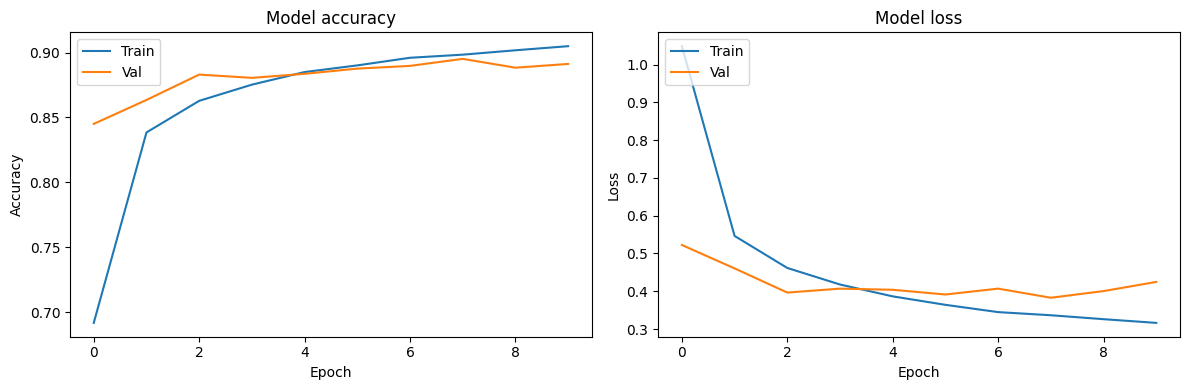

In [116]:
#matrcie de confusion
y_pred = classifier_timeshift_C.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_timeshift_C)

In [117]:
classifier_noise_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_noise_C=classifier_noise_C.train(X_train_noise_C, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_noise_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

/Users/zhile/M1-S2/DALAS/selenium_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 85s 16ms/step - accuracy: 0.4950 - loss: 1.7644 - val_accuracy: 0.8331 - val_loss: 0.5597
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - accuracy: 0.7907 - loss: 0.7054 - val_accuracy: 0.8643 - val_loss: 0.4499
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - accuracy: 0.8231 - loss: 0.5961 - val_accuracy: 0.8635 - val_loss: 0.4709
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 143s 16ms/step - accuracy: 0.8388 - loss: 0.5453 - val_accuracy: 0.8699 - val_loss: 0.4438
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8457 - loss: 0.5124 - val_accuracy: 0.8778 - val_loss: 0.4244
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 145s 16ms/step - accuracy: 0.8565 - loss: 0.4766 - val_accuracy: 0.8783 - val_loss: 0.4236
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 85s 16ms/step - accuracy: 0.8595 - loss: 0.4629 - val_accuracy: 0.8785 - val_loss: 0.4373
Epoch 8/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - accuracy: 0.8626

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


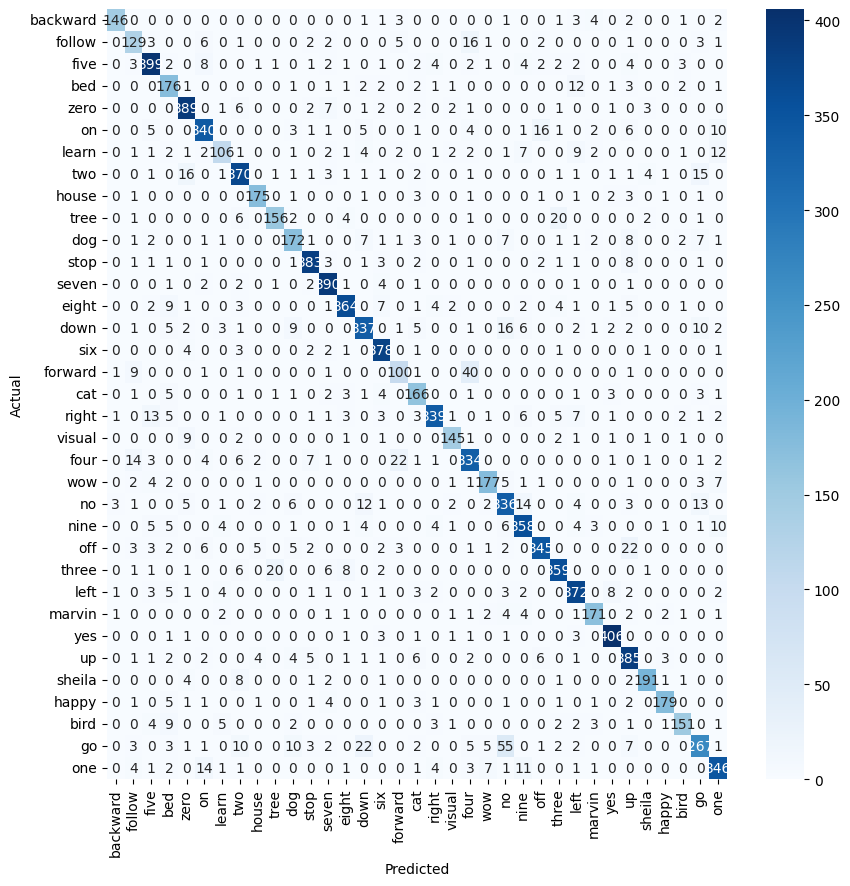

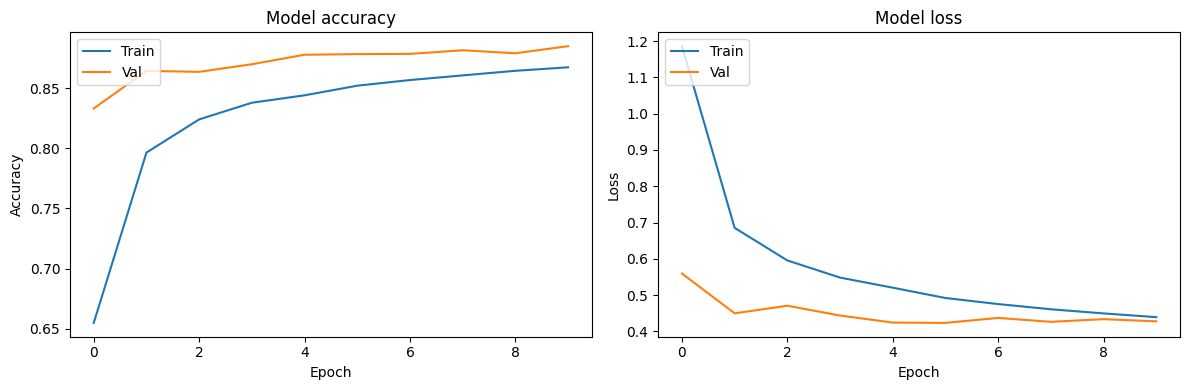

In [118]:
#matrcie de confusion
y_pred = classifier_noise_C.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_noise_C)

In [126]:
classifier_pitch_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_pitch_C = classifier_pitch_C.train(X_train_Pitch_C, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_pitch_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

/Users/zhile/M1-S2/DALAS/selenium_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step - accuracy: 0.5207 - loss: 1.6672 - val_accuracy: 0.8479 - val_loss: 0.5134
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - accuracy: 0.8106 - loss: 0.6386 - val_accuracy: 0.8636 - val_loss: 0.4524
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 74s 14ms/step - accuracy: 0.8398 - loss: 0.5331 - val_accuracy: 0.8821 - val_loss: 0.4067
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 88s 17ms/step - accuracy: 0.8566 - loss: 0.4782 - val_accuracy: 0.8790 - val_loss: 0.4184
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 90s 17ms/step - accuracy: 0.8681 - loss: 0.4420 - val_accuracy: 0.8811 - val_loss: 0.4033
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 91s 17ms/step - accuracy: 0.8722 - loss: 0.4201 - val_accuracy: 0.8860 - val_loss: 0.4070
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 94s 18ms/step - accuracy: 0.8792 - loss: 0.3993 - val_accuracy: 0.8858 - val_loss: 0.4104
Epoch 8/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 91s 17ms/step - accuracy: 0.8844 -

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


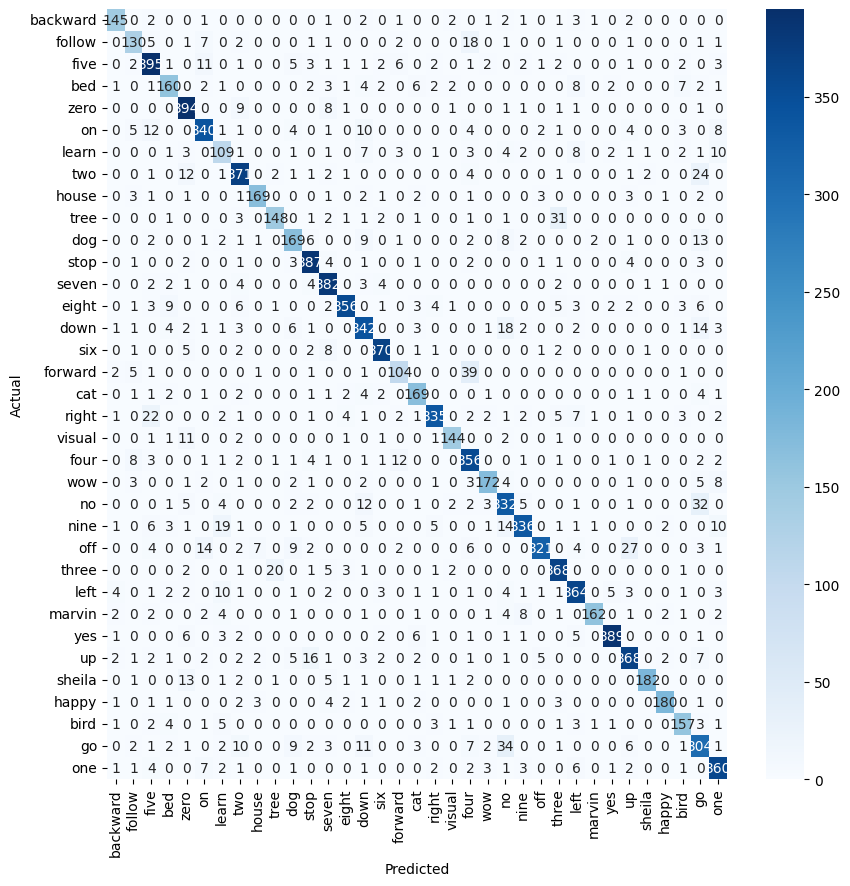

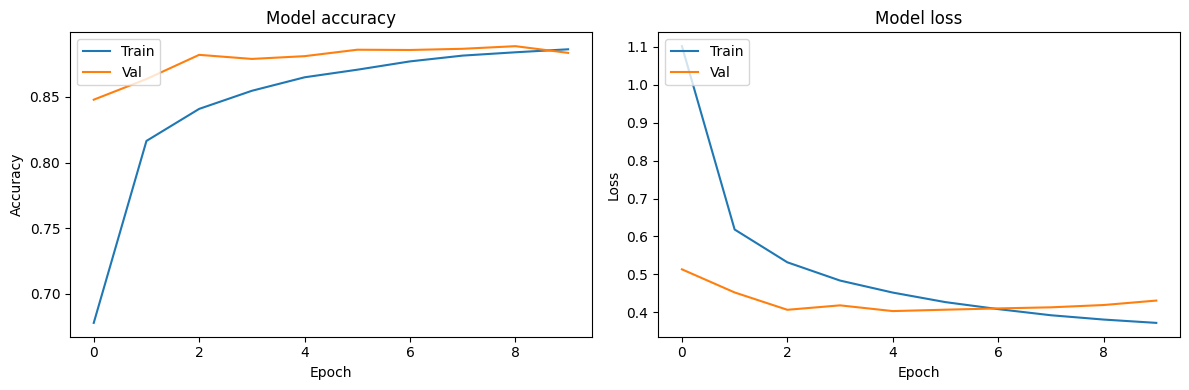

In [127]:
#matrcie de confusion
y_pred = classifier_pitch_C.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_pitch_C)

In [122]:
classifier_speed_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_speed_C=classifier_speed_C.train(X_train_Speed_C, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_speed_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 91s 17ms/step - accuracy: 0.5173 - loss: 1.6744 - val_accuracy: 0.8461 - val_loss: 0.5222
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 88s 17ms/step - accuracy: 0.8113 - loss: 0.6368 - val_accuracy: 0.8564 - val_loss: 0.4709
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 89s 17ms/step - accuracy: 0.8420 - loss: 0.5278 - val_accuracy: 0.8575 - val_loss: 0.4860
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 91s 17ms/step - accuracy: 0.8563 - loss: 0.4785 - val_accuracy: 0.8760 - val_loss: 0.4242
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 90s 17ms/step - accuracy: 0.8679 - loss: 0.4408 - val_accuracy: 0.8848 - val_loss: 0.4021
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - accuracy: 0.8754 - loss: 0.4122 - val_accuracy: 0.8815 - val_loss: 0.4129
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 91s 17ms/step - accuracy: 0.8793 - loss: 0.3968 - val_accuracy: 0.8805 - val_loss: 0.4290
Epoch 8/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 88s 17ms/step - accuracy: 0.8818 

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


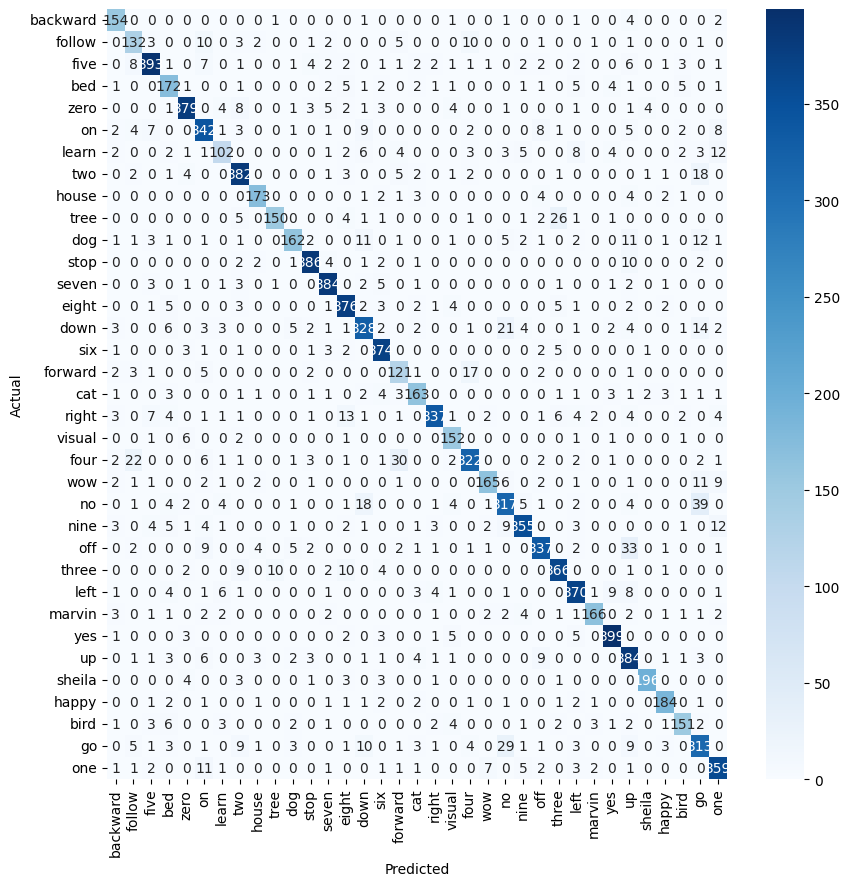

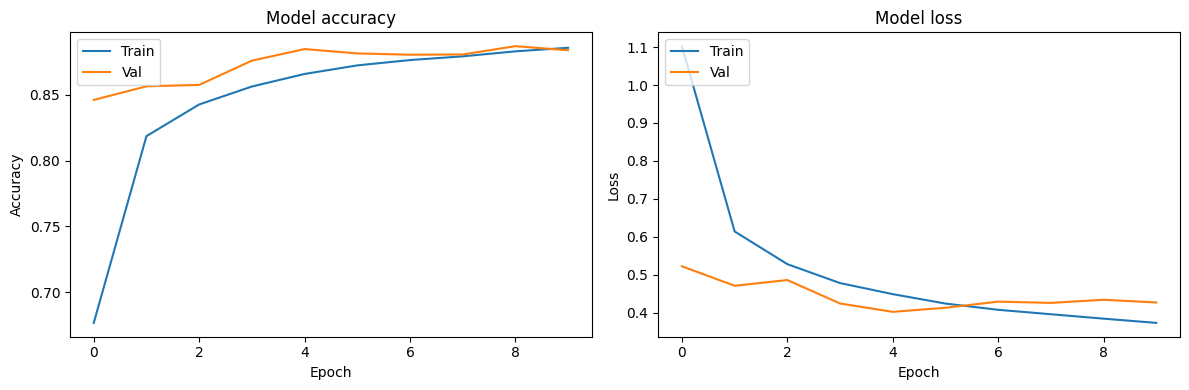

In [123]:
#matrcie de confusion
y_pred = classifier_speed_C.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_speed_C)

# LSTM

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical

class AudioLSTMClassifier:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape  
        self.num_classes = num_classes 
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            LSTM(64, input_shape=self.input_shape, return_sequences=True),
            Dropout(0.5),
            LSTM(64),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dense(self.num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, x_train, y_train, batch_size, epochs, validation_data):
        return self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data)

    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model.predict(x)


In [45]:
X_train_Non_LSTM = X_train_Non.reshape(-1, 13, 26)
X_train_masking_LSTM = X_train_masking.reshape(-1, 13, 26)
X_train_noise_LSTM = X_train_noise.reshape(-1, 13, 26)
X_train_timeshift_LSTM = X_train_timeshift.reshape(-1, 13, 26)
X_train_Pitch_LSTM = X_train_Pitch.reshape(-1, 13, 26)
X_train_Speed_LSTM = X_train_Speed.reshape(-1, 13, 26)

X_val_LSTM = X_val_Non.reshape(-1, 13, 26)
X_test_LSTM = X_test_Non.reshape(-1, 13, 26)

In [20]:
print("Shape of X_train_Non_LSTM:", X_train_Non_LSTM.shape)
print("Shape of X_val_LSTM:", X_val_LSTM.shape)


Shape of X_train_Non_LSTM: (84843, 13, 26)
Shape of X_val_LSTM: (9981, 13, 26)


In [23]:

classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_Non_LSTM, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)


/Users/zhile/M1-S2/DALAS/selenium_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - accuracy: 0.1382 - loss: 3.0762 - val_accuracy: 0.3869 - val_loss: 2.0384
Epoch 2/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.3718 - loss: 2.1200 - val_accuracy: 0.5534 - val_loss: 1.5070
Epoch 3/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.4930 - loss: 1.7120 - val_accuracy: 0.6130 - val_loss: 1.2823
Epoch 4/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.5490 - loss: 1.5157 - val_accuracy: 0.6520 - val_loss: 1.1691
Epoch 5/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.5879 - loss: 1.3965 - val_accuracy: 0.6692 - val_loss: 1.1099
Epoch 6/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.6159 - loss: 1.3051 - val_accuracy: 0.6869 - val_loss: 1.0519
Epoch 7/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6308 - loss: 1.2502 - val_accuracy: 0.7037 - val_loss: 1.0102
Epoch 8/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6508 -

In [51]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_noise_LSTM, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

/Users/zhile/M1-S2/DALAS/selenium_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.1414 - loss: 3.0549 - val_accuracy: 0.2499 - val_loss: 2.5414
Epoch 2/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.3386 - loss: 2.2022 - val_accuracy: 0.3601 - val_loss: 2.1429
Epoch 3/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.4319 - loss: 1.8996 - val_accuracy: 0.4552 - val_loss: 1.8251
Epoch 4/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.4958 - loss: 1.6948 - val_accuracy: 0.4968 - val_loss: 1.6937
Epoch 5/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.5379 - loss: 1.5489 - val_accuracy: 0.5187 - val_loss: 1.6035
Epoch 6/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.5684 - loss: 1.4573 - val_accuracy: 0.5362 - val_loss: 1.5551
Epoch 7/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.5925 - loss: 1.3840 - val_accuracy: 0.5584 - val_loss: 1.5146
Epoch 8/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.6099 - loss

In [29]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_masking_LSTM, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

/Users/zhile/M1-S2/DALAS/selenium_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.1294 - loss: 3.1139 - val_accuracy: 0.3512 - val_loss: 2.1462
Epoch 2/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.3264 - loss: 2.2822 - val_accuracy: 0.5271 - val_loss: 1.5952
Epoch 3/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.4491 - loss: 1.8677 - val_accuracy: 0.6000 - val_loss: 1.3452
Epoch 4/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.5146 - loss: 1.6439 - val_accuracy: 0.6472 - val_loss: 1.1745
Epoch 5/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 67s 25ms/step - accuracy: 0.5586 - loss: 1.4943 - val_accuracy: 0.6749 - val_loss: 1.0935
Epoch 6/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.5867 - loss: 1.4106 - val_accuracy: 0.6891 - val_loss: 1.0376
Epoch 7/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.6029 - loss: 1.3478 - val_accuracy: 0.6981 - val_loss: 0.9934
Epoch 8/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.6248 - loss:

In [30]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_timeshift_LSTM, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.1289 - loss: 3.1229 - val_accuracy: 0.3669 - val_loss: 2.1037
Epoch 2/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.3537 - loss: 2.1974 - val_accuracy: 0.5437 - val_loss: 1.5404
Epoch 3/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.4796 - loss: 1.7677 - val_accuracy: 0.6098 - val_loss: 1.3254
Epoch 4/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.5414 - loss: 1.5679 - val_accuracy: 0.6541 - val_loss: 1.1663
Epoch 5/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.5836 - loss: 1.4232 - val_accuracy: 0.6777 - val_loss: 1.0828
Epoch 6/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.6085 - loss: 1.3445 - val_accuracy: 0.6915 - val_loss: 1.0295
Epoch 7/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.6279 - loss: 1.2698 - val_accuracy: 0.7095 - val_loss: 0.9749
Epoch 8/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.6470 - loss: 1

In [48]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_Pitch_LSTM, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.1373 - loss: 3.0777 - val_accuracy: 0.4042 - val_loss: 2.0239
Epoch 2/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.3876 - loss: 2.0689 - val_accuracy: 0.5582 - val_loss: 1.4963
Epoch 3/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.4970 - loss: 1.7005 - val_accuracy: 0.6150 - val_loss: 1.2849
Epoch 4/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.5482 - loss: 1.5250 - val_accuracy: 0.6482 - val_loss: 1.1972
Epoch 5/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.5851 - loss: 1.4022 - val_accuracy: 0.6721 - val_loss: 1.1076
Epoch 6/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.6104 - loss: 1.3160 - val_accuracy: 0.6758 - val_loss: 1.0858
Epoch 7/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.6294 - loss: 1.2563 - val_accuracy: 0.6923 - val_loss: 1.0312
Epoch 8/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.6492 - lo

In [47]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_Speed_LSTM, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.1406 - loss: 3.0789 - val_accuracy: 0.4172 - val_loss: 1.9597
Epoch 2/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.4037 - loss: 2.0051 - val_accuracy: 0.5363 - val_loss: 1.5686
Epoch 3/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.5117 - loss: 1.6509 - val_accuracy: 0.6219 - val_loss: 1.2767
Epoch 4/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.5683 - loss: 1.4631 - val_accuracy: 0.6357 - val_loss: 1.1993
Epoch 5/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.6009 - loss: 1.3481 - val_accuracy: 0.6720 - val_loss: 1.1067
Epoch 6/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.6254 - loss: 1.2730 - val_accuracy: 0.6897 - val_loss: 1.0562
Epoch 7/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.6457 - loss: 1.2003 - val_accuracy: 0.6915 - val_loss: 1.0320
Epoch 8/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.6583 - l